In [17]:
import matplotlib.pyplot as plt

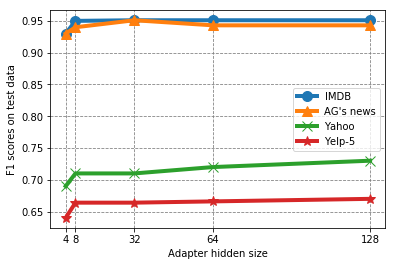

In [56]:


x = [4, 8, 32, 64, 128]
y1 = [0.93, 0.95, 0.951, 0.951, 0.951]
y2 = [0.93, 0.94, 0.951, 0.943, .943]
y3 = [0.69, 0.71, 0.71, 0.72, 0.73 ]
y4 = [0.64, 0.664, 0.664, 0.666, 0.67]

plt.plot(x,y1, marker='o', linewidth = 4, markersize=10, label = 'IMDB')
plt.plot(x,y2, marker='^', linewidth = 4, markersize=10, label = "AG's news")
plt.plot(x,y3, marker='x', linewidth = 4, markersize=10, label = "Yahoo")
plt.plot(x,y4, marker='*', linewidth = 4, markersize=10, label = "Yelp-5")

plt.xlabel('Adapter hidden size')
plt.ylabel('F1 scores on test data')
plt.grid(color='gray', linestyle='dashed')

plt.xticks(x)
plt.legend()
plt.savefig('adapter.png', dpi = 500)
plt.show()


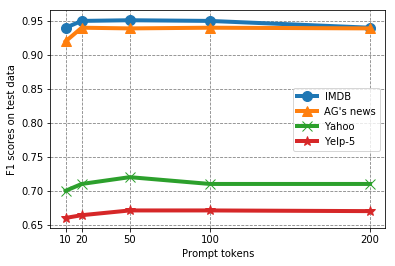

In [55]:


x = [10, 20, 50, 100, 200]
y1 = [0.94, 0.95, 0.951, 0.95, 0.94]
y2 = [0.92, 0.94, 0.939, 0.94, .939]
y3 = [0.70, 0.71, 0.72, 0.71, 0.71 ]
y4 = [0.66, 0.664, 0.671, 0.671, 0.670]

plt.plot(x,y1, marker='o', linewidth = 4, markersize=10, label = 'IMDB')
plt.plot(x,y2, marker='^', linewidth = 4, markersize=10, label = "AG's news")
plt.plot(x,y3, marker='x', linewidth = 4, markersize=10, label = "Yahoo")
plt.plot(x,y4, marker='*', linewidth = 4, markersize=10, label = "Yelp-5")

plt.xlabel('Prompt tokens')
plt.ylabel('F1 scores on test data')
plt.grid(color='gray', linestyle='dashed')

plt.xticks(x)
plt.legend()
plt.savefig('prompt.png', dpi = 500)
plt.show()




## Yelp Finetune

In [3]:
import numpy as np
import argparse
import pandas as pd

import torch
import torch.nn as nn

from torch.optim import lr_scheduler, AdamW

from dataset import create_dataset_object, load_agnews_dataset, load_imdb_dataset, load_topic_dataset, load_yelp_dataset
from dataloader import get_dataloaders

from prompt import PROMPTEmbedding
from model import APT, Prompt_Head
from utils import get_accuracy, count_parameters, freeze_params

from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaModel
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
dataset = 'yelp'   #imdb

model_type = 'roberta-base'   #roberta

number_of_tokens = 20

mode = 'finetune'


batch_size = 16

learning_rate = 2e-5

epochs = 10

In [4]:
tokenizer = RobertaTokenizer.from_pretrained(model_type)

train_text, train_labels, test_text, test_labels, valid_text, valid_labels = load_yelp_dataset(dataset)

train_data_object = create_dataset_object(train_text, train_labels, number_of_tokens, tokenizer, dataset, mode)

test_data_object  = create_dataset_object(test_text, test_labels, number_of_tokens, tokenizer, dataset, mode)

val_data_object = create_dataset_object(valid_text, valid_labels, number_of_tokens, tokenizer, dataset, mode)

dataloaders = get_dataloaders(train_data_object, test_data_object, val_data_object, batch_size)

num_labels = 5

In [5]:
model = RobertaForSequenceClassification.from_pretrained(model_type, 
                                                    num_labels=num_labels,
                                                    output_attentions=False,
                                                    output_hidden_states=False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [7]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

#Loss function
criterion = nn.CrossEntropyLoss()


optimizer = AdamW(model.parameters(), lr = learning_rate, eps=1e-8)

# Defining LR Scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=len(dataloaders['Train'])*epochs/15, 
    num_training_steps=len(dataloaders['Train'])*epochs
)

In [10]:
def train_model(config_train):

    dataset = config_train['dataset']
    dataloaders = config_train['dataloaders']
    model = config_train['model']
    device = config_train['device']
    criterion = config_train['criterion']
    optimizer = config_train['optimizer']
    mode = config_train['mode']
    scheduler = config_train['scheduler']
    epochs = config_train['epochs']
    save_checkpoint = config_train['save_checkpoint']

    checkpoint = config_train['checkpoint']


    model = model.to(device)

    best_valid_f1 = 0.0

    if save_checkpoint:
        if checkpoint != None:
            saved_model_path = checkpoint
        
        else:
            saved_model_path = dataset + "_" + mode + '.pt'

    for epoch in range(0, epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))

        for phase in ['Train', 'Val']:
            
            batch_loss = 0.0000   #live loss
            batch_acc = 0.0000   #live accuracy

            y_true = []
            y_pred = []

            if phase == 'Train':
                model.train()
            else:
                model.eval()
            
            with tqdm(dataloaders[phase], unit="batch", desc=phase) as tepoch:

                for idx, (data, labels) in enumerate(tepoch):

                    input_ids =  data['input_ids'].squeeze(1).to(device)
                    attention_mask = data['attention_mask'].squeeze(1).to(device)
                    
                    
                    labels = labels.to(device)


                    if mode =='apt':
                        output = model(input_ids = input_ids, attention_mask = attention_mask)

                    elif mode == 'finetune':
                         output = model(input_ids).logits
                    else:
                        output = model(input_ids = input_ids, attention_mask = attention_mask).logits

                    loss = criterion(output, labels)

                    if phase == 'Train':

                        #zero gradients
                        optimizer.zero_grad() 

                        # Backward pass  (calculates the gradients)
                        loss.backward()   

                        optimizer.step()             # Updates the weights
                        
                        scheduler.step()
                        
                    batch_loss += loss.item()
                        
                    _, preds = output.data.max(1)
                    y_pred.extend(preds.tolist())
                    y_true.extend(labels.tolist())
                    
                    batch_acc = get_accuracy(y_pred, y_true)
                    
                    tepoch.set_postfix(loss = batch_loss/(idx+1), accuracy = batch_acc )

                pre = precision_score(y_true, y_pred, average='weighted')
                recall = recall_score(y_true, y_pred, average='weighted')
                f1 = f1_score(y_true, y_pred, average='weighted')
                

                print("F1: {:.4f}, Precision: {:.4f}, Recall : {:.4f}.".format(f1, pre, recall))

                if save_checkpoint:
                
                    if phase == 'Val':
                        if f1 > best_valid_f1:
                            best_valid_f1 = f1
                            torch.save(model.state_dict(), saved_model_path)
                            print('Model Saved!')
                
                print()


In [11]:
config_train = {
    
    'dataset': dataset,
    'dataloaders':dataloaders, 
    'model': model, 
    'device': device, 
    'criterion':criterion, 
    'optimizer':optimizer, 
    'mode':mode, 
    'scheduler': scheduler,
    'epochs': epochs,
    'save_checkpoint': True,
    'checkpoint': None
}

train_model(config_train)

Epoch 1/10


Train: 100%|██████████| 3250/3250 [54:12<00:00,  1.00s/batch, accuracy=0.503, loss=1.09]


F1: 0.4980, Precision: 0.4998, Recall : 0.5029.



Val: 100%|██████████| 812/812 [05:32<00:00,  2.44batch/s, accuracy=0.664, loss=0.769]


F1: 0.6608, Precision: 0.6595, Recall : 0.6636.
Model Saved!

Epoch 2/10


Train: 100%|██████████| 3250/3250 [49:04<00:00,  1.10batch/s, accuracy=0.68, loss=0.734]  


F1: 0.6799, Precision: 0.6799, Recall : 0.6802.



Val: 100%|██████████| 812/812 [02:38<00:00,  5.14batch/s, accuracy=0.676, loss=0.735]


F1: 0.6701, Precision: 0.6720, Recall : 0.6759.
Model Saved!

Epoch 3/10


Train: 100%|██████████| 3250/3250 [30:29<00:00,  1.78batch/s, accuracy=0.729, loss=0.633]


F1: 0.7284, Precision: 0.7285, Recall : 0.7286.



Val: 100%|██████████| 812/812 [02:37<00:00,  5.14batch/s, accuracy=0.681, loss=0.763]


F1: 0.6799, Precision: 0.6849, Recall : 0.6806.
Model Saved!

Epoch 4/10


Train: 100%|██████████| 3250/3250 [30:29<00:00,  1.78batch/s, accuracy=0.775, loss=0.531]


F1: 0.7755, Precision: 0.7758, Recall : 0.7754.



Val: 100%|██████████| 812/812 [02:38<00:00,  5.14batch/s, accuracy=0.682, loss=0.795]


F1: 0.6812, Precision: 0.6821, Recall : 0.6817.
Model Saved!

Epoch 5/10


Train: 100%|██████████| 3250/3250 [30:28<00:00,  1.78batch/s, accuracy=0.825, loss=0.427]


F1: 0.8254, Precision: 0.8257, Recall : 0.8253.



Val: 100%|██████████| 812/812 [02:38<00:00,  5.14batch/s, accuracy=0.679, loss=0.879]


F1: 0.6802, Precision: 0.6828, Recall : 0.6792.

Epoch 6/10


Train: 100%|██████████| 3250/3250 [30:29<00:00,  1.78batch/s, accuracy=0.871, loss=0.329]


F1: 0.8710, Precision: 0.8712, Recall : 0.8710.



Val: 100%|██████████| 812/812 [02:38<00:00,  5.13batch/s, accuracy=0.68, loss=1.01]  


F1: 0.6800, Precision: 0.6807, Recall : 0.6800.

Epoch 7/10


Train: 100%|██████████| 3250/3250 [30:30<00:00,  1.78batch/s, accuracy=0.908, loss=0.242]


F1: 0.9081, Precision: 0.9082, Recall : 0.9080.



Val: 100%|██████████| 812/812 [02:37<00:00,  5.14batch/s, accuracy=0.674, loss=1.18]


F1: 0.6729, Precision: 0.6737, Recall : 0.6741.

Epoch 8/10


Train: 100%|██████████| 3250/3250 [30:30<00:00,  1.78batch/s, accuracy=0.935, loss=0.176]


F1: 0.9354, Precision: 0.9354, Recall : 0.9354.



Val: 100%|██████████| 812/812 [02:37<00:00,  5.14batch/s, accuracy=0.671, loss=1.3] 


F1: 0.6716, Precision: 0.6724, Recall : 0.6712.

Epoch 9/10


Train: 100%|██████████| 3250/3250 [30:30<00:00,  1.78batch/s, accuracy=0.956, loss=0.128]


F1: 0.9559, Precision: 0.9559, Recall : 0.9559.



Val: 100%|██████████| 812/812 [02:37<00:00,  5.14batch/s, accuracy=0.672, loss=1.46]


F1: 0.6722, Precision: 0.6734, Recall : 0.6716.

Epoch 10/10


Train: 100%|██████████| 3250/3250 [30:29<00:00,  1.78batch/s, accuracy=0.966, loss=0.0999]


F1: 0.9655, Precision: 0.9655, Recall : 0.9655.



Val: 100%|██████████| 812/812 [02:38<00:00,  5.14batch/s, accuracy=0.672, loss=1.5] 

F1: 0.6727, Precision: 0.6743, Recall : 0.6717.



In [57]:
import os

In [58]:
def test_model(config_test):

    model = config_test['model']
    test_loader = config_test['test_loader']
    device = config_test['device']
    criterion = config_test['criterion']
    mode = config_test['mode']

    model = model.to(device)


    batch_loss = 0.0   #batch loss
    batch_acc = 0.0   #batch accuracy

    y_true = []
    y_pred = []

    # set the model to evaluation mode            
    model.eval()

    phase = 'Test'

    with tqdm(test_loader, unit="batch", desc=phase) as tepoch:
        
        for idx, (data, labels) in enumerate(tepoch):
            
            input_ids =  data['input_ids'].squeeze(1).to(device)
            attention_mask = data['attention_mask'].squeeze(1).to(device)

            labels = labels.to(device)
            
            with torch.no_grad():


                if mode =='apt':
                    output = model(input_ids = input_ids, attention_mask = attention_mask)

                elif mode == 'finetune':
                        output = model(input_ids).logits
                else:
                    output = model(input_ids = input_ids, attention_mask = attention_mask).logits

                loss = criterion(output, labels)
                
                _, preds = output.data.max(1)
                y_pred.extend(preds.tolist())
                y_true.extend(labels.tolist())
                
                batch_acc = get_accuracy(y_pred, y_true)
                batch_loss += loss.item()
                
            tepoch.set_postfix(loss = batch_loss/(idx+1), accuracy = batch_acc )


    pre = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print("")

    print("F1: {:.6f}, Precision: {:.6f}, Recall : {:.6f}".format(f1, pre, recall))


In [59]:

saved_model_path = dataset + "_" + mode + '.pt'



if os.path.exists(saved_model_path):
    model.load_state_dict(torch.load(saved_model_path))
    print("Model checkpoint loaded succesfully")

else:
    print("Required model checkpoint not found!\n")
    raise FileNotFoundError

config_test = {

'model': model, 
'test_loader':dataloaders['Test'], 
'device': device, 
'criterion':criterion,
'mode':mode
}

test_model(config_test)

Model checkpoint loaded succesfully


Test: 100%|██████████| 3125/3125 [09:52<00:00,  5.27batch/s, accuracy=0.678, loss=0.81] 


F1: 0.677306, Precision: 0.678364, Recall : 0.677520
